# Tutorial: Plot Galaxy Rotation Curve with SDSS-IV MaNGA data
In this tutorial, we use [SDSS-IV MaNGA](https://www.sdss.org/surveys/manga/) data to measure line of sight velocity and plot rotation curve of galaxy. 
## Required packages
* NUMPY: v1.14.3
* SCIPY: v1.1.0
* MATPLOTLIB: v2.2.2
* ASTROPY: v3.0.4
* PPXF: v6.7.1 (included in the distribution)

In [24]:
# import required packages
import numpy as np
from math import pi
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from time import process_time as clock
from astropy.io import fits
import urllib.request
import os.path
# from ppxf_wrap import ppxf_wrap

%matplotlib inline
# set inline figure size


In [ ]:
def airtovac(wave):
    for i in range(2):
          sigma2 = (1d4/double(wave_vac[g]) )^2.     ;Convert to wavenumber squared

; Compute conversion factor
  fact = 1.D +  5.792105D-2/(238.0185D0 - sigma2) + $
                            1.67917D-3/( 57.362D0 - sigma2)


  wave_vac[g] = wave_air[g]*fact              ;Convert Wavelength
  endfor


In [34]:
import numpy as np
from astropy.io import fits
import glob
from ppxf import ppxf
import ppxf_util as util
class ppxf_wrap():
    def __init__(self, redshift, wave, specres):
        wave=wave/(1+redshift) #  When measure velocity from IFS observation, 
                                        # deredshift to the barycenter should be applied before measuement.
        specres=specres/(1+redshift)
        
# Only use the wavelength range in common between galaxy and stellar library.
#         mask = (t['loglam'] > np.log10(3540)) & (t['loglam'] < np.log10(7409))     
        mask = (wave > 3540) & (wave < 7409)
        mask = (wave > 3850) & (wave < 7309)
#         loglam_gal = np.log10(wave[mask])
        lam_gal = wave[mask]
        specres=specres[mask]

        c = 299792.458                  # speed of light in km/s
        frac = lam_gal[1]/lam_gal[0]    # Constant lambda fraction per pixel
        fwhm_gal=lam_gal/specres          # Resolution FWHM of every pixel, in Angstroms
        velscale = np.log(frac)*c       # Constant velocity scale in km/s per pixel

        file_dir='./'
        galaxy_templates=glob.glob(file_dir+'Mun1.30Z*.fits')
        fwhm_tem=2.51 # Vazdekis+10 spectra have a constant resolution FWHM of 2.51A.
        hdu = fits.open(galaxy_templates[0])
        ssp = hdu[0].data
        h2 = hdu[0].header
        lam_temp = h2['CRVAL1'] + h2['CDELT1']*np.arange(h2['NAXIS1'])
        lamRange_temp = [np.min(lam_temp), np.max(lam_temp)]
        sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale)[0]
        templates = np.empty((sspNew.size, len(galaxy_templates)))
#        dv = np.log(lam_temp[0]/lam_gal[0])*c    # km/s
        
        fwhm_gal = np.interp(lam_temp, lam_gal, fwhm_gal)        
        fwhm_dif = np.sqrt((fwhm_gal**2 - fwhm_tem**2).clip(0))
        sigma = fwhm_dif/2.355/h2['CDELT1'] # Sigma difference in pixels

        goodpixels = util.determine_goodpixels(np.log(lam_gal), lamRange_temp, 0)
        dv = np.log(lam_temp[0]/lam_gal[0])*c    # km/s
        
        for j, fname in enumerate(galaxy_templates):
            hdu = fits.open(fname)
            ssp = hdu[0].data
            ssp = util.gaussian_filter1d(ssp, sigma)  # perform convolution with variable sigma
            sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale)[0]
            templates[:, j] = sspNew/np.median(sspNew) # Normalizes templates
                
        self.templates=templates
        self.flux=None
        self.ivar=None
        self.specres=specres
        self.mask=mask
        self.lam_gal=lam_gal
        self.lam_temp=lam_temp
        self.dv=dv
        self.goodpixels=goodpixels
        self.velscale=velscale
#         self.lamRange_temp=lamRange_temp
         
        
    def run(self):
        c = 299792.458                  # speed of light in km/s
        flux=(self.flux)[self.mask]
        noise=(self.ivar**(-0.5))[self.mask]
        
        specres=self.specres
        templates=self.templates
        lam_gal=self.lam_gal
        lam_temp=self.lam_temp
        dv=self.dv
        goodpixels=self.goodpixels
        velscale=self.velscale
#         nmask=(np.isfinite(noise) & (noise > 0))
#        dv=self.dv
#         print(dv)
#         print(velscale)
        

#         flux = flux[nmask]
#         galaxy = flux/np.median(flux)   # Normalize spectrum to avoid numerical issues
#         noise = noise[nmask]/np.median(flux)
#         lam_gal=lam_gal[nmask]
        
        
        galaxy = flux/np.median(flux)   # Normalize spectrum to avoid numerical issues
        noise = noise/np.median(flux)
        
#         goodpixels = util.determine_goodpixels(np.log(lam_gal), self.lamRange_temp, 0)
#         dv = np.log(lam_temp[0]/lam_gal[0])*c    # km/s


        if not np.all(np.isfinite(galaxy)):
            return False
        if not np.all((noise > 0) & np.isfinite(noise)):
            return False

# Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
#         vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
        start = [0, 200.]  # (km/s), starting guess for [V, sigma]
        
        adegree=0
        mdegree=0
        pp=ppxf(templates, galaxy, noise, velscale, start,
                  goodpixels=goodpixels, plot=False, quiet=True, moments=2,
                  degree=adegree, mdegree=mdegree, vsyst=dv, clean=False, lam=lam_gal)
        self.fflux=galaxy
        return pp


---
## Download MaNGA Data & Catalog
Download MaNGA cube data and catalog from SDSS-IV DR14 Science Archieve Server (https://data.sdss.org/sas/dr14/)

* MaNGA data access <https://www.sdss.org/dr14/manga/manga-data/data-access/>

We use logarithmically-binned cube data (LOGCUBE)

(-0.5, 561.5, 561.5, -0.5)

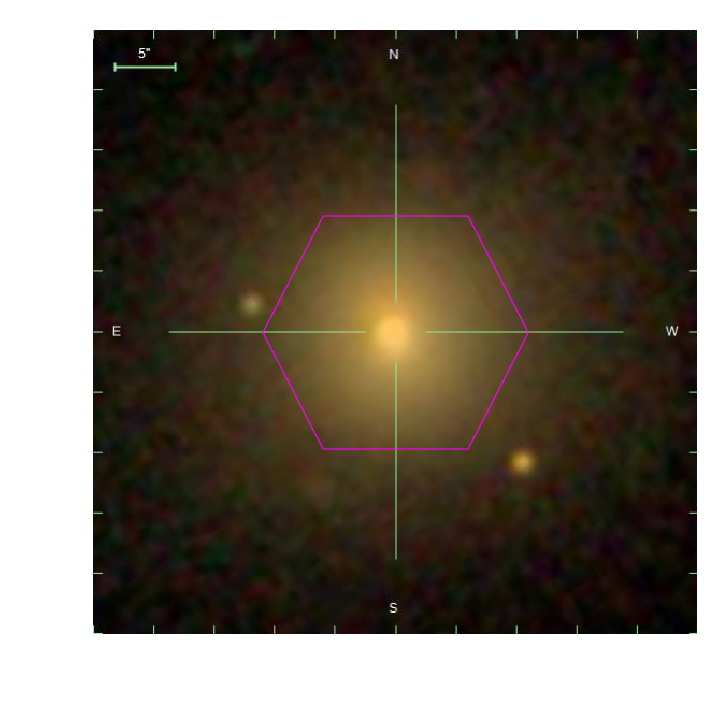

In [6]:
# plateifu of galaxy to download data
plateifu='8329-6103' # Spiral Galaxy
plateifu='8137-6103' # Elliptical Galaxy


plate, ifuname=plateifu.split('-')
cdir='./'  #current directory

# MaNGA cube file
cube_file='manga-'+plateifu+'-LOGCUBE.fits.gz'   # file to de downloaded

# download MaNGA cube file if not exist.
if not os.path.isfile(cdir+cube_file):
    sas_url="https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/"
    print("Start downloading "+cube_file+" from SDSS server. This may take several minutes.")
    urllib.request.urlretrieve(sas_url+plate+'/stack/'+cube_file, cdir+cube_file)
    print('Downloaded complete')


# MaNGA Catalog file (DR14)
drpall_file="drpall-v2_1_2.fits"

# download drpall file if not exist.
if not os.path.isfile(cdir+drpall_file):
    sas_url="https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/"
    print("Start downloading "+drpall_file+" from SDSS server. This may take several seconds.")
    urllib.request.urlretrieve(sas_url+"drpall-v2_1_2.fits", cdir+drpall_file)    
    print('Downloaded complete')
    
image_file=plateifu+'.png'
if not os.path.isfile(cdir+image_file):
    sas_url="https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/"
    print("Start downloading "+image_file+" from SDSS server. This may take several seconds.")
    urllib.request.urlretrieve(sas_url+plate+'/stack/images/'+ifuname+'.png', cdir+image_file)
    print('Downloaded complete')
    
# Show MaNGA galaxy image
fig=plt.figure(figsize=(4,4), dpi=200)
plt.imshow(mpimg.imread(cdir+image_file),aspect='equal')
plt.axis('off')

---
## Read galaxy information
In this tutorial, we need information of galaxy on
* Redshift(z)
* B/A ratio (inclination)
* Position Angle (PA)

MaNGA catalog file (drpall-v2_1_2.fits) contains above information for each galaxy.

In [7]:
drpall=fits.open(cdir+drpall_file)
tbdata=drpall[1].data
idx=np.where(tbdata['plateifu'] == plateifu)
objra=tbdata['objra'][idx][0]
objdec=tbdata['objdec'][idx][0]
nsa_z=tbdata['nsa_z'][idx][0]
nsa_elpetro_phi=tbdata['nsa_elpetro_phi'][idx][0]
nsa_elpetro_ba=tbdata['nsa_elpetro_ba'][idx][0]

print("Galaxy: ",plateifu)
print("RA, DEC:", objra, ',',objdec)
print("Redshift: ",nsa_z)
print("Position angle (degree): ", nsa_elpetro_phi)
print("b/a ratio: ", nsa_elpetro_ba)
print('More info: http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx?ra=%0.6f&dec=%0.6f&scale=0.2' % (objra, objdec))

# print(tbdata.columns.names)

Galaxy:  8137-6103
RA, DEC: 116.782606045 , 43.3140748538
Redshift:  0.0416588
Position angle (degree):  3.76447
b/a ratio:  0.927868
More info: http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx?ra=116.782606&dec=43.314075&scale=0.2


---
## Read galaxy cube data
Read and explore MaNGA Cube data.
In this tutorial, we are going to
- Plot galaxy spectrum at particular spaxel
- Plot galaxy intensity map

In [8]:
# Open and read flux, inverse variance, and mask cube.
cube = fits.open(cdir+cube_file)
flux=np.transpose(cube['FLUX'].data, axes=(2, 1, 0))
ivar=np.transpose(cube['IVAR'].data, axes=(2, 1, 0))
mask = np.transpose(cube['MASK'].data, axes=(2, 1, 0))
wave = cube['WAVE'].data
specres = cube['SPECRES'].data

flux_header = cube['FLUX'].header

### Plot galaxy spectrum
* Plot galaxy spectrum at the galaxy center.
* User can plot other part by changing x_plot and y_plot

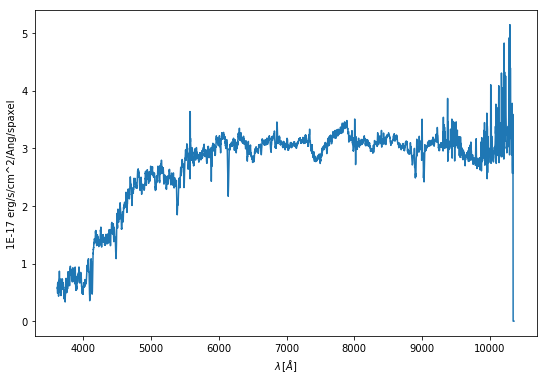

Cube 2D size:  54 by 54


In [9]:
#plot manga spectrum at the center
x_center = np.int(flux_header['CRPIX1']) - 1
y_center = np.int(flux_header['CRPIX2']) - 1

x_plot=x_center
y_plot=y_center

# User can plot other part of the galaxy
#x_plot=28
#y_plot=35

# fig=plt.figure(figsize=(9, 6))
matplotlib.rcParams['figure.figsize'] = [9, 6]
plt.plot(wave, flux[x_plot, y_plot])
plt.xlabel('$\lambda \, [\AA]$')
plt.ylabel(flux_header['BUNIT'])
plt.show()
# plt.rcParams['figure.figsize'] = [9, 6]

print('Cube 2D size: ', flux.shape[0], 'by', flux.shape[1])

### Plot galaxy intensity map around H$_{\alpha}$
* Integrate spectrum flux around H$_{\alpha}$ (6563 Angstrom) line. 
    * restframe 6550 to 6680 Angstrom
* Plot intensity map

Text(0,0.5,'arcsec')

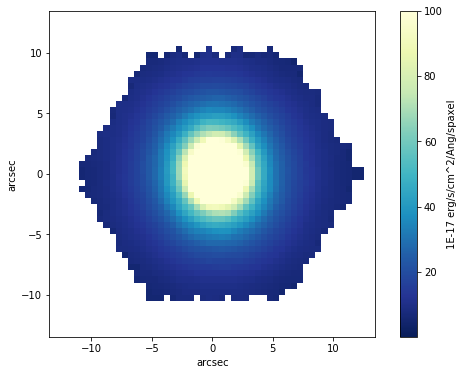

In [10]:
# process flux data 
do_not_use = (mask & 2**10) != 0
flux_m = np.ma.array(flux, mask=do_not_use)
ivar_m = np.ma.array(ivar, mask=do_not_use)

min_wave=6550
max_wave=6680
redshift = nsa_z
ind_wave = np.where((wave / (1 + redshift) > min_wave) & (wave / (1 + redshift) < max_wave))[0]
halpha = flux_m[:, :, ind_wave].sum(axis=2) # integrate flux along wavelength vector
im = halpha.T #Transpose numpy array

# Convert from array indices to arcsec relative to IFU center
dx = flux_header['CD1_1'] * 3600.  # deg to arcsec
dy = flux_header['CD2_2'] * 3600.  # deg to arcsec
x_extent = (np.array([0., im.shape[0]]) - (im.shape[0] - x_center)) * dx * (-1)
y_extent = (np.array([0., im.shape[1]]) - (im.shape[1] - y_center)) * dy
extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]

plt.imshow(im, extent=extent, cmap=cm.YlGnBu_r, vmin=0.1, vmax=100, origin='lower', interpolation='none')
plt.colorbar(label=flux_header['BUNIT'])
plt.xlabel('arcsec')
plt.ylabel('arcsec')

---
## Extract galaxy kinematics
* We use Penalized Pixel-Fitting method (pPXF) developed by Michele Cappellari to extract stellar kinematics of galaxy. 
    * http://www-astro.physics.ox.ac.uk/~mxc/software/#ppxf
    * pPXF(v6.7.1) in Python is included in this tutorial package. (ppxf.py and ppxf_util.py)
* pPXF fits template spectrum to the given galaxy spectrum to fit the galaxy kinematics.
* Four galaxy templates from MILES library is used in this tutorial.
    * Vazdekis (2010, MNRAS, 404, 1639) http://miles.iac.es/.
    * Metalicity (log(Z/Z_solar)=0), age: 1 Gyr, 2 Gyr, 8 Gyr, and 10 Gyr
        * Mun1.30Zp0.00T01.0000_iPp0.00_baseFe_linear_FWHM_2.51.fits
        * Mun1.30Zp0.00T07.9433_iPp0.00_baseFe_linear_FWHM_2.51.fits
        * Mun1.30Zp0.00T01.9953_iPp0.00_baseFe_linear_FWHM_2.51.fits
        * Mun1.30Zp0.00T10.0000_iPp0.00_baseFe_linear_FWHM_2.51.fits

* The warpper of pPXF is written separatly in ppxf_wrap.py.

### Measure line of sight velocity using ppxf_wrap
* To measure velocity in your own machine, **set run_vel_measure = True**. Otherwise, we use pre-saved result.
* ppxf_wrap measures velocity at each spaxel, one by one.
* Result will be saved in FITS format.

 i  j   Velocity Dispersion  Chi2    t


/home/hchung/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/hchung/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


20 06    130.976    156.302  0.77  0.3
21 06    156.113    163.372  1.04  0.3
22 06    136.185    164.718  0.80  0.7
23 06    -84.164    151.455  0.50  6.6
25 06    134.561    182.126  0.80  1.4
26 06    150.756    194.724  1.06  1.1
27 06    106.463    156.185  0.70  1.9
30 06     54.639    172.639  0.56  1.5
31 06    155.413    181.146  1.05  0.5
32 06    122.805    188.521  0.75  1.2
36 06    166.541    198.069  0.96  0.8
37 06    127.036    110.462  0.78  2.3
17 07    124.486    202.744  1.04  0.2
18 07    115.770    222.156  1.00  0.3
19 07    124.100    215.057  0.98  0.6
20 07    143.577    179.368  0.95  0.4
21 07    154.871    158.989  1.00  0.6
22 07    162.477    168.501  1.09  0.6
23 07    167.006    179.356  1.07  0.6
24 07    165.965    190.921  1.02  0.4
25 07    148.725    191.333  0.93  0.3
26 07    153.637    197.278  1.06  0.7
27 07    128.517    189.714  0.87  0.3
28 07    147.798    207.943  0.96  1.7
29 07    160.023    211.177  0.93  0.3
30 07    128.242    165.3

23 14    174.766    195.447  1.55  0.3
24 14    178.446    198.491  1.85  1.1
25 14    182.176    192.718  1.82  1.6
26 14    184.199    189.394  1.73  3.6
27 14    185.646    184.388  1.78  1.4
28 14    189.718    187.202  1.84  0.9
29 14    189.295    190.554  1.84  1.5
30 14    184.470    188.202  1.78  1.6
31 14    180.931    188.379  1.70  2.8
32 14    179.300    187.849  1.90  2.3
33 14    180.375    185.599  1.83  2.2
34 14    176.814    186.333  1.79  3.6
35 14    170.187    182.424  1.80  0.5
36 14    165.695    183.117  1.47  0.6
37 14    159.448    186.097  1.22  0.5
38 14    157.193    191.312  1.02  1.7
39 14    159.218    197.201  1.01  0.5
40 14    163.097    195.833  1.13  0.6
41 14    168.766    199.172  1.19  0.6
42 14    163.875    198.375  1.16  0.4
43 14    153.556    192.234  1.21  0.6
44 14     59.233    148.913  0.64  4.5
11 15    125.893    172.784  1.00  3.3
12 15    128.194    179.430  1.12  0.8
13 15    131.390    183.345  1.11  1.5
14 15    136.009    193.5

21 20    166.123    218.632  1.36  0.5
22 20    172.473    226.430  2.24  0.6
23 20    174.997    218.678  1.87  0.5
24 20    181.047    216.207  2.35  0.7
25 20    189.887    214.823  2.42  0.7
26 20    194.342    218.578  2.63  0.3
27 20    189.197    219.072  2.97  0.6
28 20    182.535    214.684  2.48  1.8
29 20    179.153    217.763  3.05  0.3
30 20    176.519    215.410  2.00  1.1
31 20    177.853    216.929  2.09  0.4
32 20    174.060    217.161  1.70  0.5
33 20    169.451    221.356  1.83  1.1
34 20    162.878    225.530  1.92  0.6
35 20    156.182    218.916  1.50  0.5
36 20    153.479    217.567  1.44  0.8
37 20    144.354    213.325  1.42  0.6
38 20    138.873    211.493  1.53  0.5
39 20    135.072    211.207  1.47  0.8
40 20    133.023    203.449  1.34  0.3
41 20    131.217    201.734  1.16  0.3
42 20    128.930    193.093  1.14  0.4
43 20    127.633    188.046  1.13  0.8
44 20    118.305    183.802  1.11  0.8
45 20    107.032    175.912  1.17  0.3
46 20     97.440    169.8

22 25    125.513    265.346  5.71  0.4
23 25    129.899    258.555  6.38  0.6
24 25    138.229    277.049 17.19  0.4
25 25    138.608    279.367 23.98  0.8
26 25    135.751    275.286 28.74  0.7
27 25    133.026    276.364 28.27  0.3
28 25    132.509    279.145 24.47  0.5
29 25    133.154    274.178 22.07  0.6
30 25    132.947    256.223 17.31  0.6
31 25    133.341    249.493  9.98  0.7
32 25    132.355    245.512  6.04  1.2
33 25    132.251    247.509  4.33  0.4
34 25    124.266    230.746  3.37  0.4
35 25    111.236    218.099  1.80  0.7
36 25    107.758    215.218  1.59  0.6
37 25    113.084    215.267  1.52  0.3
38 25    121.825    218.419  1.42  0.3
39 25    126.063    213.594  1.45  0.5
40 25    121.669    200.354  1.41  0.6
41 25    120.646    198.115  1.45  0.4
42 25    119.775    205.025  1.48  0.6
43 25    115.756    209.704  1.34  0.8
44 25    108.720    215.012  1.18  0.3
45 25    107.010    214.513  1.10  0.3
46 25    105.491    221.029  1.12  0.4
47 25     95.760    217.9

11 30    100.734    191.700  1.10  1.2
12 30    107.232    193.072  1.11  0.6
13 30    103.342    193.918  1.16  1.5
14 30     97.348    191.632  1.37  0.5
15 30     87.346    190.414  1.42  0.4
16 30     81.789    195.804  1.36  0.7
17 30     82.472    210.188  1.57  0.7
18 30     85.639    226.175  1.71  0.5
19 30     87.255    234.975  2.88  0.5
20 30     83.515    239.439  4.09  0.4
21 30     78.179    242.497  4.00  0.3
22 30     80.956    255.726  9.97  0.4
23 30     82.413    266.653 12.72  0.6
24 30     84.859    274.637 25.43  0.4
25 30     87.042    282.426 34.09  1.8
26 30     87.719    285.989 30.15  0.4
27 30     89.972    285.045 42.87  0.3
28 30     92.500    296.771 35.26  0.6
29 30     92.181    293.703 35.50  0.4
30 30     89.413    277.687 18.16  0.4
31 30     86.376    259.438 10.83  0.6
32 30     83.851    247.818  6.34  0.4
33 30     84.718    247.912  6.29  0.5
34 30     86.805    239.148  4.43  0.4
35 30     92.332    227.332  2.41  0.5
36 30    101.755    226.6

24 35     29.703    224.636  1.70  0.5
25 35     32.773    236.841  3.10  0.4
26 35     31.787    241.035  3.65  0.3
27 35     30.227    237.110  4.37  0.5
28 35     30.374    232.334  4.23  1.4
29 35     34.488    228.641  3.31  0.3
30 35     42.188    232.393  3.07  0.3
31 35     49.495    229.482  2.43  0.7
32 35     55.142    223.956  2.53  0.6
33 35     57.393    212.861  1.99  1.3
34 35     62.639    213.053  1.81  0.5
35 35     71.398    218.316  1.61  0.6
36 35     82.517    224.836  1.37  0.6
37 35     91.787    225.102  1.45  0.8
38 35     99.867    223.904  1.47  4.9
39 35    100.483    222.156  1.37  0.7
40 35    100.928    214.702  1.28  1.7
41 35     99.959    213.840  1.15  1.4
42 35     93.768    205.074  1.16  2.4
43 35     82.455    194.483  1.19  1.3
44 35     78.318    192.987  1.10  3.3
45 35     77.923    184.032  1.09  3.6
46 35     87.909    179.031  1.12  3.0
10 36     68.193    133.253  0.74  3.9
11 36     94.841    185.905  1.44  0.5
12 36     87.222    187.4

30 41     31.326    191.305  1.53  0.4
31 41     38.382    191.435  1.46  0.7
32 41     42.314    196.661  1.48  0.5
33 41     48.931    203.189  1.44  0.3
34 41     55.264    206.732  1.43  0.4
35 41     63.023    203.941  1.47  0.4
36 41     71.412    206.756  1.41  0.6
37 41     73.010    206.901  1.54  0.4
38 41     77.627    216.279  1.57  0.7
39 41     74.026    207.712  1.48  0.5
40 41     74.533    205.207  1.56  0.9
41 41     73.877    199.476  1.34  0.7
42 41     34.788    176.911  1.06  0.4
13 42    113.384    204.117  1.45  0.7
14 42    114.656    198.602  1.35  0.7
15 42    110.532    192.599  1.25  0.9
16 42     95.921    184.070  1.33  0.5
17 42     82.223    183.960  1.40  0.3
18 42     66.026    188.163  1.29  0.7
19 42     60.420    196.862  1.43  1.3
20 42     56.995    202.117  1.41  2.6
21 42     46.973    192.991  1.38  1.1
22 42     39.800    191.286  1.47  0.7
23 42     28.999    183.273  1.25  0.8
24 42     26.770    188.273  1.28  1.1
25 42     24.559    194.7

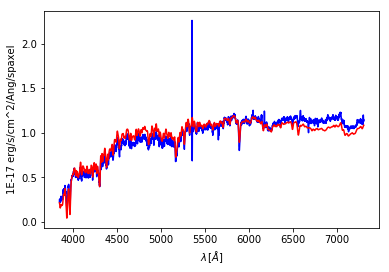

In [36]:
run_vel_measure=True

oname=cdir+'manga-'+plateifu+'-LOGCUBE_MAPS.fits'

# i, j index of spaxel to show comaparison result
check_i=27
check_j=27

if run_vel_measure:
    redshift=nsa_z
    ppxf_obj=ppxf_wrap(redshift, wave, specres)
    nx, ny, _ = flux.shape
    resarr=np.zeros((nx,ny))
    flagarr=np.zeros((nx,ny),dtype=np.int16) #define flag array
    t = clock()
    check_flag=False
    print("%2s %2s %10s %10s %5s %4s" % ('i', 'j', 'Velocity', 'Dispersion', 'Chi2', 't'))
    for j in range(nx):
        for i in range(ny):
            t = clock()
            if np.median(flux_m[i,j]) > 0:
                ppxf_obj.flux=flux_m[i,j]
                ppxf_obj.ivar=ivar_m[i,j]
                
                res=ppxf_obj.run()
                if not res:
                    continue
                resarr[i,j]=res.sol[0]
                flagarr[i,j]=1
                if i == check_i & j == check_j:
                    check_flag=True
                    sflux=ppxf_obj.fflux
                    sbestfit=res.bestfit
                print("%02d %02d %10.3f %10.3f %5.2f %4.1f" % (i, j, res.sol[0], res.sol[1], res.chi2, clock()-t))

    if check_flag:
        plt.plot(ppxf_obj.lam_gal, sflux, 'b-')
        plt.plot(ppxf_obj.lam_gal, sbestfit, 'r-')
        plt.xlabel('$\lambda \, [\AA]$')
        plt.ylabel(flux_header['BUNIT'])

    print('Save velocity measurement data in to FITS file: ', oname)
    hdu = fits.PrimaryHDU()
    hdu.writeto(oname, overwrite=True)

    fits.append(oname, resarr)
    fits.append(oname, flagarr.astype(np.int16))

    append_file=fits.open(oname, mode='update')

    hdr=append_file[1].header
    hdr.set('EXTNAME','STELLAR_VEL')
    hdr=append_file[2].header
    hdr['EXTNAME']='FLAG'

    append_file.close()

---
## Read and plot 2D velocity map
* Use pre-saved file when user skipped the previous part.

107.10349880469944


Text(0,0.5,'arcsec')

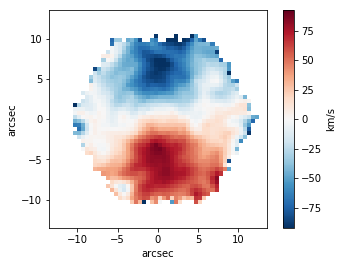

In [37]:
# read velocity map file
rfile='manga-'+plateifu+'-LOGCUBE_MAPS.fits'
if not os.path.isfile(cdir+rfile): # use pre-saved file if above one not exist.
    rfile='manga-'+plateifu+'-LOGCUBE_MAPS_SAVED.fits'
    
cube = fits.open(cdir+rfile)
velmap=cube['STELLAR_VEL'].data
nx, ny=np.int(flux_header['NAXIS1']) , np.int(flux_header['NAXIS2'])

# Plot 2D map
# Calculate velocity statistics (median and standard deviation) to re-scale map values for plot)
pvelmap=velmap.T
zero_idx=(pvelmap == 0)
pvelmap[zero_idx]=np.nan
finite_idx=np.isfinite(pvelmap)
medv, stdv, sigv=(np.median(pvelmap[finite_idx]), np.std(pvelmap[finite_idx]), 2)
pvelmap=pvelmap-medv
print(medv)
cmap= matplotlib.cm.RdBu_r
cmap.set_bad(color='white')
plt.imshow(pvelmap, extent=extent, cmap=cmap, vmin=(-stdv*sigv), vmax=stdv*sigv, origin='lower', interpolation='none')
plt.colorbar(label='km/s')
plt.xlabel('arcsec')
plt.ylabel('arcsec')

---
## Plot rotation curve
<img src="./gal_rot.png" alt="Drawing" style="width: 800px;"/>

* To plot rotation curve, $V(r)$, we need to perform coordinate transform of line of sight 2D velocity map into galactic coordinate system.
* A relation between $V_{LOS}$ and $V(r)$ is given as above.
* We will use known value of $V_{SYS}$, inclination angle $i$, and position angle $\phi_{0}$. All we need to do is calculating $r$ and $cos(\phi-\phi_{0})$
* How to calculate $r$ and $cos(\phi-\phi_{0})$ from $r'$ and $cos(\phi'-\phi'_{0})$ ?
    * $r\,cos(\phi-\phi_{0})=r' cos(\phi'-\phi'_{0})$ and $\phi_{0}=\phi'_{0}$
    * From tangent half-angle formula: $tan(\phi'/2)=y'/(x'+r')$
    * $tan(\phi-\phi_{0})=tan(\phi'-\phi_{0})\,cos\,i$
    * here $\phi_{0}=nsa\_elpetro\_phi+\pi/2$

In [ ]:
incl, phi0, cent_x, cent_y = np.arccos(nsa_elpetro_ba), (nsa_elpetro_phi+90)/180*pi, 0, 0

# below values from rotation model fitting (8329-6103)
# incl, phi0, cent_x, cent_y = 1.0487251 , 0.49254251+pi/2, 0.46911521, 0.45171812

# below values from rotation model fitting (8137-6103)
# incl, phi0, cent_x, cent_y = 0.81853998, 0.036205037+pi/2, 0.18230028, 0.32383320

aidx=np.arange(nx*ny)
ix=aidx % nx
iy=aidx // ny

x_obs=(ix-(nx/2-0.5))*0.5 # one pixel size correspond to 0.5 arcsec
y_obs=(iy-(ny/2-0.5))*0.5
r_obs=((x_obs-cent_x)**2+(y_obs-cent_y)**2)**0.5

tan_half_phi_obs=((y_obs-cent_y)/(x_obs-cent_x+r_obs))

phi_obs=2*np.arctan(tan_half_phi_obs)
tan_phi_gal=np.tan(phi_obs-phi0)/np.cos(incl)  # here phi_gal means phi_gal - PA_gal
cos_phi_gal=1/((1+tan_phi_gal**2)**0.5)

# calculate r_gal and v_rot
r_gal=r_obs*np.cos(phi_obs-phi0)/cos_phi_gal
v_rot=pvelmap.flatten()/cos_phi_gal/np.sin(incl)

# plot points only within +/- 20 degree from major axis
max_angle=20
major_idx=np.flatnonzero(np.abs((phi_obs-phi0)/pi*180 % 180 ) < max_angle)
r_gal=r_gal[major_idx]
v_rot=v_rot[major_idx]

ymax=np.max(v_rot[np.isfinite(np.abs(v_rot))])
xmax=np.max(r_gal[np.isfinite(np.abs(r_gal))])
ymul=1.3

plt.plot(r_gal, v_rot, 'ko')
xlim=plt.xlim()
plt.plot([-xmax, xmax], [0,0], 'r--')
plt.plot([0,0], [-ymax*ymul,ymax*ymul], 'r--')

plt.xlabel('$r_{gal}$ (arcsec)')
plt.ylabel('$V_{ROT}$ (km/s) ')
plt.ylim([-ymax*ymul,ymax*ymul])
plt.xlim(xlim)